In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, ZeroPadding2D, PReLU, Cropping2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import activations
from tensorflow.keras.layers.experimental.preprocessing import Resizing

import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)
#tf.keras.backend.set_floatx('float16')

height_lr = 68
width_lr = 90
channels = 3
shape_lr = (height_lr, width_lr, channels)
shape_hr = (4*height_lr, 4*width_lr, channels)
data_num = 7
data_dir = f"../../datasets/dataset_0{data_num}/"

activation = 'relu'
regularizer = regularizers.l1(1e-9)
dropout_ratio = 0.25
batch_size = 1
learning_rate = 0.0005


## Encoder: MaxPooling, Conv2D(Stride=(1,1))
## Decoder: Conv2DTranspose, add

In [5]:
input_img = Input(shape_lr)
#Encoder
l1_0 = ZeroPadding2D(padding=(0, 1))(input_img)
l1_1 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l1_0)
l1_2 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l1_1)
l1_3 = MaxPooling2D(padding='same')(l1_2)
l2_1 = Conv2D(128, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l1_3)
l2_2 = Conv2D(128, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l2_1)
l2_3 = MaxPooling2D(padding='same')(l2_2)
l3_1 = Conv2D(256, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l2_3)
#Decoder
l4_1 = Conv2DTranspose(128, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l3_1)
l4_2 = Conv2D(128, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l4_1)
l4_3 = add([l4_2, l2_2])
l5_1 = Conv2DTranspose(64, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l4_3)
l5_2 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l5_1)
l5_3 = add([l5_2, l1_2])
l6_1 = Conv2DTranspose(32, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l5_3)
l6_2 = Conv2D(32, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l6_1)
l7_1 = Conv2DTranspose(16, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l6_2)
l7_2 = Conv2D(16, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l7_1)
#Output
l8_1 = Conv2D(3, (3, 3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l7_2)
#l8_2 = Resizing(272, 360, interpolation='bilinear')(l8_1)
l8_2 = Cropping2D(cropping=((0,0),(0,8)))(l8_1)

autoencoder = Model(input_img, l8_2)
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 68, 90, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 68, 92, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 68, 92, 64)   1792        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 68, 92, 64)   36928       conv2d_10[0][0]                  
____________________________________________________________________________________________

## Encoder: MaxPooling, Conv2D
## Decoder: Upsampling2D, Conv2D, add

In [2]:

input_img = Input(shape_lr)

l1_0 = ZeroPadding2D(padding=(0, 1))(input_img)
l1_1 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizers.l1(10e-10))(l1_0)
l1_2 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizers.l1(10e-10))(l1_1)
l1_3 = MaxPooling2D(padding='same')(l1_2)
l1_4 = Dropout(dropout_ratio)(l1_3)
l2_1 = Conv2D(128, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizers.l1(10e-10))(l1_4)
l2_2 = Conv2D(128, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizers.l1(10e-10))(l2_1)
l2_3 = MaxPooling2D(padding='same')(l2_2)
l3_1 = Conv2D(256, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizers.l1(10e-10))(l2_3)

l4_1 = UpSampling2D()(l3_1)
l4_2 = Conv2D(128, (3, 3), padding='same', activation=activation,
            activity_regularizer=regularizers.l1(10e-10))(l4_1)
l4_3 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4_2)
l5_1 = add([l2_2, l4_3])
l5_2 = UpSampling2D()(l5_1)
l5_3 = Conv2D(64, (3, 3), padding='same', activation=activation,
             activity_regularizer=regularizers.l1(10e-10))(l5_2)
l5_4 = Conv2D(64, (3, 3), padding='same', activation=activation,
             activity_regularizer=regularizers.l1(10e-10))(l5_3)
l6_1 = add([l5_4, l1_2])
l6_2 = UpSampling2D()(l6_1)
l6_3 = Conv2D(32, (3, 3), padding='same', activation=activation,
             activity_regularizer=regularizers.l1(10e-10))(l6_2)
l6_4 = Conv2D(32, (3, 3), padding='same', activation=activation,
             activity_regularizer=regularizers.l1(10e-10))(l6_3)
l7_1 = UpSampling2D()(l6_4)
l7_2 = Conv2D(16, (3, 3), padding='same', activation=activation,
            activity_regularizer=regularizers.l1(10e-10))(l7_1)
l7_3 = Conv2D(3, (3, 3), padding='same', activation=activation,
            activity_regularizer=regularizers.l1(10e-10))(l7_2)
#l7_4 = Resizing(272, 360, interpolation='bilinear')(l7_3)
l7_4 = Cropping2D(cropping=((0,0),(0,8)))(l7_3)
autoencoder = Model(input_img, l7_4)
autoencoder.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 68, 90, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 68, 92, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 68, 92, 64)   1792        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 68, 92, 64)   36928       conv2d[0][0]                     
______________________________________________________________________________________________

## Encoder: Conv2D(Stride=(1,1)), Conv2D(Stride=(2,2))
## Decoder: Conv2DTranspose, Conv2D(Stride=(1,1)), add

In [2]:
input_img = Input(shape_lr)
#Encoder
l1_0 = ZeroPadding2D(padding=(0, 1))(input_img)
l1_1 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l1_0)
l1_2 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l1_1)
l1_3 = Dropout(dropout_ratio)(l1_2)
l2_1 = Conv2D(128, (3,3), strides=(2,2), padding='same', activation=activation,
            activity_regularizer=regularizer)(l1_3)
l2_2 = Conv2D(128, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l2_1)
l2_3 = Dropout(dropout_ratio)(l2_2)
l3_1 = Conv2D(256, (3,3), strides=(2,2), padding='same', activation=activation,
            activity_regularizer=regularizer)(l2_3)
#Decoder
l4_1 = Conv2DTranspose(128, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l3_1)
l4_2 = Conv2D(128, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l4_1)
l4_3 = add([l4_2, l2_2])
l5_1 = Conv2DTranspose(64, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l4_3)
l5_2 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l5_1)
l5_3 = add([l5_2, l1_2])
l6_1 = Conv2DTranspose(32, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l5_3)
l6_2 = Conv2D(32, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l6_1)
l7_1 = Conv2DTranspose(16, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l6_2)
l7_2 = Conv2D(16, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l7_1)
#Output
l8_1 = Conv2D(3, (3, 3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l7_2)
#l8_2 = Resizing(272, 360, interpolation='bilinear')(l8_1)
l8_2 = Cropping2D(cropping=((0,0),(0,8)))(l8_1)

autoencoder = Model(input_img, l8_2)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 68, 90, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 68, 92, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 68, 92, 64)   1792        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 68, 92, 64)   36928       conv2d[0][0]                     
______________________________________________________________________________________________

## Encoder: Conv2D(Stride=(1,1)),BatchNormalize, Conv2D(Stride=(2,2)), BatchNormalize, PReLU
## Decoder: Conv2DTranspose, BatchNormalize, Conv2D(Stride=(1,1)), BatchNormalize, PReLU, add

In [2]:
input_img = Input(shape=shape_lr)
l0 = ZeroPadding2D(padding=(0, 1))(input_img)

#Encoder
l1_1 = Conv2D(64, (3,3), padding='same', activity_regularizer=regularizer)(l0)
l1_2 = BatchNormalization()(l1_1)
l1_3 = PReLU()(l1_2)

l2_1 = Conv2D(64, (3,3), padding='same', activity_regularizer=regularizer)(l1_3)
l2_2 = BatchNormalization()(l2_1)
l2_3 = PReLU()(l2_2)

l3_1 = Conv2D(128, (3,3), padding='same',strides=(2,2), activity_regularizer=regularizer)(l2_3)
l3_2 = BatchNormalization()(l3_1)
l3_3 = PReLU()(l3_2)

l4_1 = Conv2D(128, (3,3), padding='same', activity_regularizer=regularizer)(l3_3)
l4_2 = BatchNormalization()(l4_1)
l4_3 = PReLU()(l4_2)

l5_1 = Conv2D(256, (3,3), padding='same',strides=(2,2), activity_regularizer=regularizer)(l4_3)
l5_2 = BatchNormalization()(l5_1)
l5_3 = PReLU()(l5_2)

#Decoder
l6_1 = Conv2DTranspose(128, (3,3), padding='same', strides=(2,2), activity_regularizer=regularizer)(l5_3)
l6_2 = BatchNormalization()(l6_1)
l6_3 = PReLU()(l6_2)

l7_1 = Conv2D(128, (3,3), padding='same', activity_regularizer=regularizer)(l6_3)
l7_2 = BatchNormalization()(l7_1)
l7_3 = PReLU()(l7_2)
l7_4 = add([l7_3, l4_3])

l8_1 = Conv2DTranspose(64, (3,3), padding='same', strides=(2,2), activity_regularizer=regularizer)(l7_4)
l8_2 = BatchNormalization()(l8_1)
l8_3 = PReLU()(l8_2)

l9_1 = Conv2D(64, (3,3), padding='same', activity_regularizer=regularizer)(l8_3)
l9_2 = BatchNormalization()(l9_1)
l9_3 = PReLU()(l9_2)
l9_4 = add([l9_3, l2_3])

l10_1 = Conv2DTranspose(32, (3,3), padding='same', strides=(2,2), activity_regularizer=regularizer)(l9_4)
l10_2 = BatchNormalization()(l10_1)
l10_3 = PReLU()(l10_2)

l11_1 = Conv2D(32, (3,3), padding='same', activity_regularizer=regularizer)(l10_3)
l11_2 = BatchNormalization()(l11_1)
l11_3 = PReLU()(l11_2)

l12_1 = Conv2DTranspose(16, (3,3), padding='same', strides=(2,2), activity_regularizer=regularizer)(l11_3)
l12_2 = BatchNormalization()(l12_1)
l12_3 = PReLU()(l12_2)

l13_1 = Conv2D(16, (3,3), padding='same', activity_regularizer=regularizer)(l12_3)
l13_2 = BatchNormalization()(l13_1)
l13_3 = PReLU()(l13_2)

#Output
l14_1 = Conv2D(3, (3, 3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l13_3)
l14_2 = Cropping2D(cropping=((0,0),(0,8)))(l14_1)

autoencoder = Model(input_img, l14_2)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 68, 90, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 68, 92, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 68, 92, 64)   1792        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 68, 92, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

## Encoder: Conv2D(Stride=(1,1)), Conv2D(Stride=(2,2)), BatchNormalize, PReLU
## Decoder: Conv2DTranspose, Conv2D(Stride=(1,1)), BatchNormalize, PReLU, add

In [2]:
input_img = Input(shape=shape_lr)
l0 = ZeroPadding2D(padding=(0, 1))(input_img)

#Encoder
l1_1 = Conv2D(64, (3,3), padding='same', activity_regularizer=regularizer)(l0)
l1_2 = Conv2D(64, (3,3), padding='same', activity_regularizer=regularizer)(l1_1)
l1_3 = BatchNormalization()(l1_2)
l1_4 = PReLU()(l1_3)

l2_1 = Conv2D(128, (3,3), padding='same',strides=(2,2), activity_regularizer=regularizer)(l1_4)
l2_2 = Conv2D(128, (3,3), padding='same', activity_regularizer=regularizer)(l2_1)
l2_3 = BatchNormalization()(l2_2)
l2_4 = PReLU()(l2_3)

l3_1 = Conv2D(256, (3,3), padding='same',strides=(2,2), activity_regularizer=regularizer)(l2_4)
l3_2 = BatchNormalization()(l3_1)
l3_3 = PReLU()(l3_2)

#Decoder
l6_1 = Conv2DTranspose(128, (3,3), padding='same', strides=(2,2), activity_regularizer=regularizer)(l3_3)
l6_2= Conv2D(128, (3,3), padding='same', activity_regularizer=regularizer)(l6_1)
l6_3 = BatchNormalization()(l6_2)
l6_4 = PReLU()(l6_3)
l6_5 = add([l6_4, l2_4])

l7_1 = Conv2DTranspose(64, (3,3), padding='same', strides=(2,2), activity_regularizer=regularizer)(l6_5)
l7_2 = Conv2D(64, (3,3), padding='same', activity_regularizer=regularizer)(l7_1)
l7_3 = BatchNormalization()(l7_2)
l7_4 = PReLU()(l7_3)
l7_5 = add([l7_4, l1_4])

l8_1 = Conv2DTranspose(32, (3,3), padding='same', strides=(2,2), activity_regularizer=regularizer)(l7_5)
l8_2 = Conv2D(32, (3,3), padding='same', activity_regularizer=regularizer)(l8_1)
l8_3 = BatchNormalization()(l8_2)
l8_4 = PReLU()(l8_3)

l9_1 = Conv2DTranspose(16, (3,3), padding='same', strides=(2,2), activity_regularizer=regularizer)(l8_4)
l9_2 = Conv2D(16, (3,3), padding='same', activity_regularizer=regularizer)(l9_1)
l9_3 = BatchNormalization()(l9_2)
l9_4 = PReLU()(l9_3)

#Output
l10_1 = Conv2D(3, (3, 3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l9_4)
l10_2 = Cropping2D(cropping=((0,0),(0,8)))(l10_1)

autoencoder = Model(input_img, l10_2)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 68, 90, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 68, 92, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 68, 92, 64)   1792        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 68, 92, 64)   36928       conv2d[0][0]                     
______________________________________________________________________________________________

## Training

In [3]:
adam = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [4]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, batch_size=4, dim=(272, 360, 3),
                    n_channels=1, n_classes=1, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        #self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        #print(list_IDs)

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print(f'Batch index: {index}')
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'full', filename)
                image_y = pyplot.imread(filepath)
                filepath = os.path.join(data_dir+'quarter', filename)
                image_x = pyplot.imread(filepath)
                if len(image_y.shape) > 2 and len(image_x.shape) > 2:
                    #Y.append(resize(image_y, (self.dim[0], self.dim[1]+8)))
                    Y.append(image_y)
                    X.append(image_x)
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)
        #print(f'Length of X: {len(X)}')
        return X, Y

In [5]:
files = os.listdir(data_dir+'full')
#print(len(files))
dataGenerator = DataGenerator(files, batch_size=batch_size)
history = autoencoder.fit(dataGenerator, verbose=1, epochs=1)

FileNotFoundError: [Errno 2] No such file or directory: '../../datasets/dataset_07/full'

## Results

In [1]:
image_name = files[random.randint(0, len(files))]
full_image = pyplot.imread(os.path.join(data_dir+'full', image_name))
quarter_image = pyplot.imread(os.path.join(data_dir+'quarter', image_name))
pred_image = np.expand_dims(quarter_image, 0)
pred_image = autoencoder.predict(pred_image)
pred_image = np.array(pred_image, dtype=int)
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(full_image)
ax = plt.subplot(10, 10, 2)
plt.imshow(pred_image[0])
ax = plt.subplot(10, 10, 3)
plt.imshow(resize(quarter_image, (shape_hr[0], shape_hr[1])))
ax = plt.subplot(10, 10, 4)
plt.imshow(quarter_image)

NameError: name 'files' is not defined

(544, 720, 3)
(16, 68, 90, 3)
(16, 272, 360, 3)
(1088, 1440, 3)


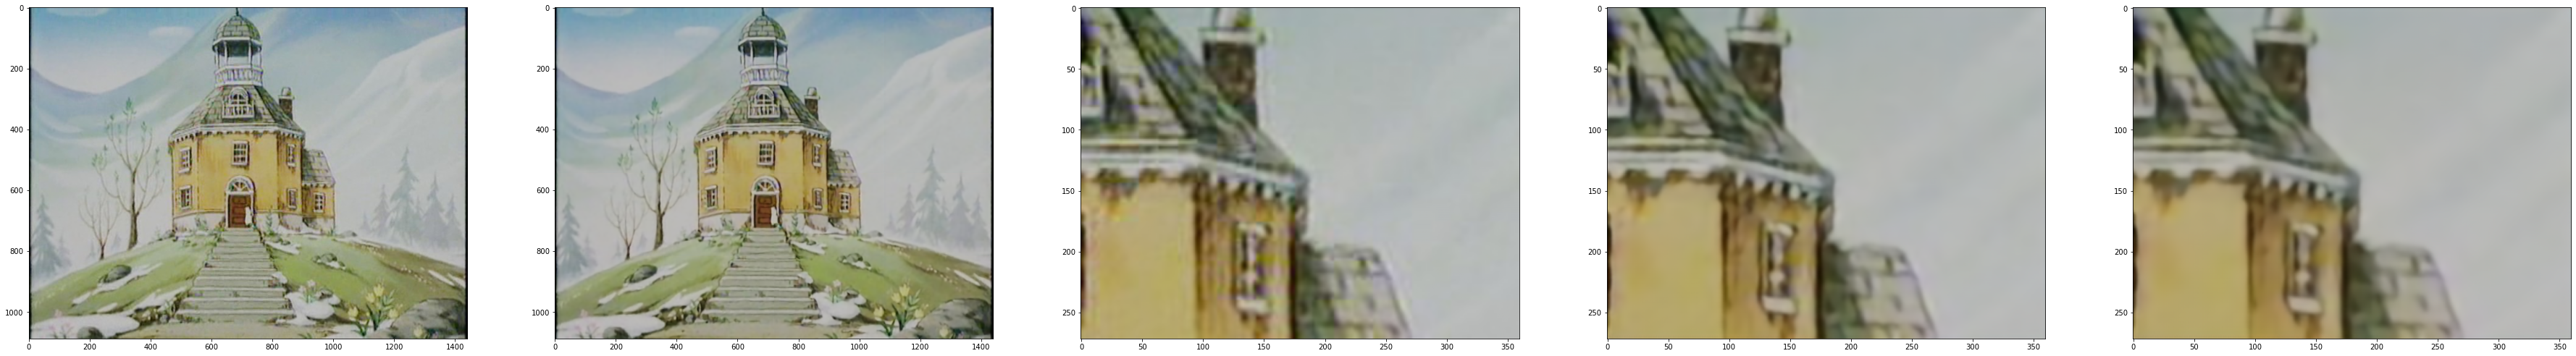

In [69]:
full_image = pyplot.imread(os.path.join('../../datasets/full_frames', '2.jpg'))
full_size = full_image.shape
print(full_size)
quater_images = np.empty((16, full_size[0]//8, full_size[1]//8, 3), dtype=float)
quater_images_og = np.empty((16, full_size[0]//4, full_size[1]//4, 3), dtype=float)
quater_images_scaled = np.empty((16, full_size[0]//2, full_size[1]//2, 3), dtype=float)
scaled_image = np.empty((full_size[0]*2, full_size[1]*2, 3), dtype=float)
quater_image_4x = np.empty((full_size[0]//2, full_size[1]//2, 3), dtype=float)
k = 0
for i in range(0, 4):
    for j in range(0, 4):
        x_s = int((i/4.)*full_size[0])
        x_e = int(((i+1)/4.)*full_size[0])
        y_s = int((j/4.)*full_size[1])
        y_e = int(((j+1)/4.)*full_size[1])
        #print(f'x: {x_s}:{x_e} | {y_s}:{y_e}')
        #temp = full_image[x_s:x_e, y_s:y_e]
        #temp = resize(temp,(full_size[0]//2, full_size[1]//2))
        quater_images[k] = resize(full_image[x_s:x_e, y_s:y_e],
            (full_size[0]//8, full_size[1]//8))
        quater_images_og[k] = (1./255) * full_image[x_s:x_e, y_s:y_e]
        k += 1
print(quater_images.shape)

for i in range(0, 16):
    temp = np.expand_dims(quater_images[i], 0)
    temp = autoencoder.predict(temp)
    quater_images_scaled[i] = temp[:]
print(quater_images_scaled.shape)
print(scaled_image.shape)

k = 0
for i in range(0, 4):
    for j in range(0, 4):
        x_s = int((i/4.)*full_size[0]*2)
        x_e = int(((i+1)/4.)*full_size[0]*2)
        y_s = int((j/4.)*full_size[1]*2)
        y_e = int(((j+1)/4.)*full_size[1]*2)
        #print(f'x: {x_s}:{x_e} | {y_s}:{y_e}')
        #print(scaled_image[x_s:x_e, y_s:y_e].shape)
        scaled_image[x_s:x_e, y_s:y_e] = quater_images_scaled[k]
        k += 1

seqment = 6
quater_image_4x = autoencoder.predict(np.expand_dims(resize(quater_images_scaled[seqment], (full_size[0]//8, full_size[1]//8)), 0))

#print(full_image[40][40][:])
#print(quater_images[0][10][10][:])
#print(quater_images_scaled[0][10][10][:])
#print(scaled_image[40][40][:])

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(resize(full_image, (2*full_size[0], 2*full_size[1])))
ax = plt.subplot(10, 10, 2)
plt.imshow(scaled_image)
ax = plt.subplot(10, 10, 3)
plt.imshow(resize(quater_images_og[seqment], (2*quater_images_og.shape[1], 2*quater_images_og.shape[2])))
ax = plt.subplot(10, 10, 4)
plt.imshow(quater_images_scaled[seqment])
ax = plt.subplot(10, 10, 5)
plt.imshow(quater_image_4x[0])

(544, 720, 3)
(64, 68, 90, 3)
(64, 272, 360, 3)
(2176, 2880, 3)


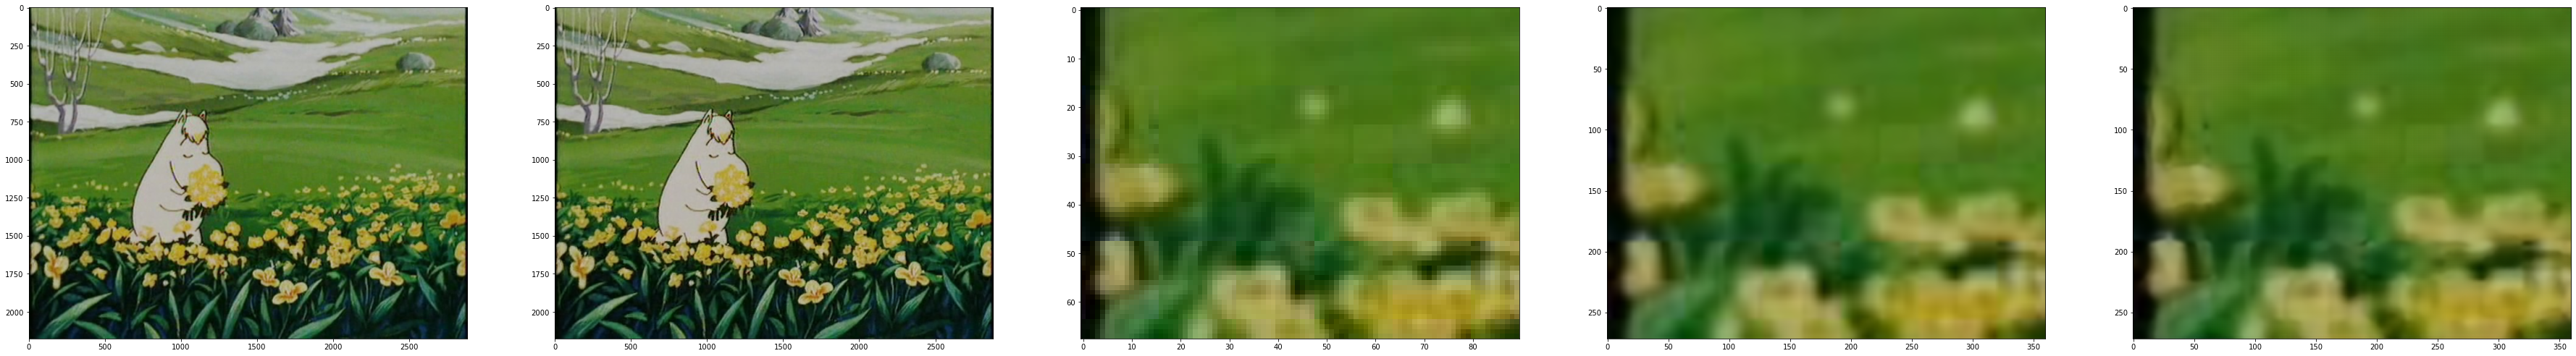

In [75]:
#4x
full_image = pyplot.imread(os.path.join('../../datasets/full_frames', '3.jpg'))
full_size = full_image.shape
print(full_size)
eigth_images = np.empty((64, full_size[0]//8, full_size[1]//8, 3), dtype=float)
eigth_images_scaled = np.empty((64, full_size[0]//2, full_size[1]//2, 3), dtype=float)
scaled_image = np.empty((full_size[0]*4, full_size[1]*4, 3), dtype=float)

k = 0
for i in range(0, 8):
    for j in range(0, 8):
        x_s = int((i/8.)*full_size[0])
        x_e = int(((i+1)/8.)*full_size[0])
        y_s = int((j/8.)*full_size[1])
        y_e = int(((j+1)/8.)*full_size[1])
        #print(f'x: {x_s}:{x_e} | {y_s}:{y_e}')
        #temp = full_image[x_s:x_e, y_s:y_e]
        #temp = resize(temp,(full_size[0]//2, full_size[1]//2))
        eigth_images[k] = (1./255) * full_image[x_s:x_e, y_s:y_e]
        k += 1
print(eigth_images.shape)

for i in range(0, 64):
    temp = np.expand_dims(eigth_images[i], 0)
    temp = autoencoder.predict(temp)
    eigth_images_scaled[i] = temp[:]
print(eigth_images_scaled.shape)
print(scaled_image.shape)

k = 0
for i in range(0, 8):
    for j in range(0, 8):
        x_s = int((i/8.)*full_size[0]*4)
        x_e = int(((i+1)/8.)*full_size[0]*4)
        y_s = int((j/8.)*full_size[1]*4)
        y_e = int(((j+1)/8.)*full_size[1]*4)
        #print(f'x: {x_s}:{x_e} | {y_s}:{y_e}')
        #print(scaled_image[x_s:x_e, y_s:y_e].shape)
        scaled_image[x_s:x_e, y_s:y_e] = eigth_images_scaled[k]
        k += 1

seqment = 32
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(resize(full_image, (4*full_size[0], 4*full_size[1])))
ax = plt.subplot(10, 10, 2)
plt.imshow(scaled_image)
ax = plt.subplot(10, 10, 3)
plt.imshow(eigth_images[seqment])
ax = plt.subplot(10, 10, 4)
plt.imshow(resize(eigth_images[seqment], (4*eigth_images.shape[1], 4*eigth_images.shape[2])))
ax = plt.subplot(10, 10, 5)
plt.imshow(eigth_images_scaled[seqment])